In [8]:
%load_ext autoreload
%autoreload 2

import pytorch_lightning as pl
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
from pytorch_lightning.loggers import TensorBoardLogger
import os
import torch
import torch.nn.functional as F
import random
import numpy as np
import cv2
import torch.nn as nn
from PIL import Image
import timm
# import warnings
# warnings.filterwarnings("ignore")

root_dir = "/".join( os.getcwd().split("/")[:-1])
data_dir = os.path.join(root_dir, "data")
root_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/home/deepam_minda_farmart_co/fmt/skew_correction'

In [2]:
def tensor_to_pil(img):
    return Image.fromarray((img.numpy() * 255).astype('uint8').transpose(1,2,0))

In [3]:
torch.cuda.is_available()


True

## Dataset and dataloader

In [507]:
# Dataset

data_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    # transforms.GaussianBlur(3),
    # transforms.ColorJitter(0.3),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class SkewAngleDataset(Dataset):
    def __init__(self, data_dir, skew_range=(-30, 30), step_size=5, transform=None):

        self.data_dir = data_dir
        self.transform = transform
        self.skew_range = skew_range
        self.step_size = step_size
        self.ang2index = {0:0, 90:1, -90:2, 180:3}

        # List all image file names in the data directory
        self.image_files = [x for x in os.listdir(data_dir) if x[-3:]=='jpg']

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        # print(img_name)
        image = Image.open(img_name)

        # Apply skew angle
        # skew_angle = random.uniform(self.skew_range[0], self.skew_range[1])
        skew_angle = random.choice([0,90])
        # skew_angle = round(skew_angle / self.step_size) * self.step_size
        
        # print(f"inside {skew_angle}")
        image = image.rotate(skew_angle, expand=True)

        if self.transform:
            image = self.transform(image)

        label = self.ang2index[skew_angle]

        return image, torch.tensor(label, dtype=torch.long)




In [508]:
# [x for x in os.listdir(os.path.join(data_dir, 'images')) if x[-3:]=='jpg']

In [509]:
dataset = SkewAngleDataset(data_dir=os.path.join(data_dir, 'images'), transform=data_transform)

1


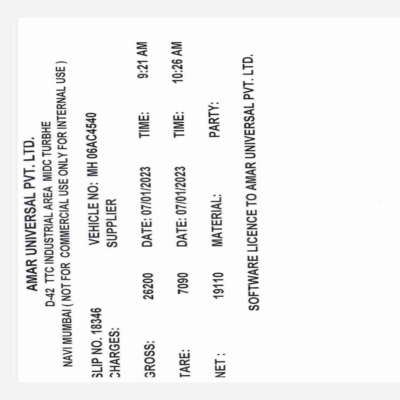

In [510]:
# test dataset

idx=15
img, angle = dataset[idx]
print(angle.item())

tensor_to_pil(img) 

In [511]:
# Split dataset into train and test
train_ratio = 0.8
test_ratio = 0.2

train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [512]:
train_batch_size = 4
val_batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=True)

In [513]:
next(iter(train_loader))[1]

tensor([0, 0, 0, 1])

### lightning data module

In [514]:
import torch
from torch.utils.data import random_split
import pytorch_lightning as pl

class MyDataModule(pl.LightningDataModule):
    def __init__(self, dataset, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42, train_batch_size=4, val_batch_size=4):
        super().__init__()
        self.dataset = dataset
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.seed = seed
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size

    def setup(self, stage=None):
        # Calculate the sizes of train atasets
        total_size = len(self.dataset)
        train_size = int(self.train_ratio * total_size)
        
        # Calculate the test size and val sizes
        if self.test_ratio > 0:
            val_size = int(self.val_ratio * total_size)
            test_size = total_size - train_size - val_size
            self.train_ds, self.val_ds, self.test_ds = random_split(
                self.dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(self.seed)
            )
        else:
            val_size = total_size - train_size
            self.train_ds, self.val_ds = random_split(
                self.dataset, [train_size, val_size], generator=torch.Generator().manual_seed(self.seed)
            )

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.train_batch_size, shuffle=True, ) 

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.val_batch_size, shuffle=True) 

    def test_dataloader(self):
        if self.test_ratio > 0:
            return DataLoader(self.test_ds, batch_size=self.val_batch_siz)
        else:
            return None

    def predict_dataloader(self):
        if self.test_ratio > 0:
            return pl.DataLoader(self.test_ds, batch_size=32)
        else:
            return None


In [515]:
dataset = SkewAngleDataset(data_dir=os.path.join(data_dir, 'images'), transform=data_transform)
data_module = MyDataModule(dataset, train_ratio=0.8, val_ratio=0.2, test_ratio=0.0, train_batch_size=16, val_batch_size=4)

In [516]:
data_module.setup()  
next(iter(data_module.train_dataloader()))

[tensor([[[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0118],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0118],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           ...,
           [0.0078, 0.0039, 0.0078,  ..., 0.0745, 0.0667, 0.0667],
           [0.0078, 0.0078, 0.0078,  ..., 0.0941, 0.0706, 0.0706],
           [0.0118, 0.0118, 0.0118,  ..., 0.0941, 0.0706, 0.0902]],
 
          [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0118],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0118],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
           ...,
           [0.0078, 0.0039, 0.0078,  ..., 0.0549, 0.0471, 0.0510],
           [0.0078, 0.0078, 0.0078,  ..., 0.0745, 0.0549, 0.0549],
           [0.0118, 0.0118, 0.0118,  ..., 0.0745, 0.0549, 0.0745]],
 
          [[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0118],
           [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0078, 0.0118],
           [0.0039, 0.00

In [517]:
# it = (iter(data_module.train_dataloader()))
# next(it)[0].shape

## Modeilling

### CNN model

In [518]:
# verbose = True
# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=0),
#             # nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
#             # nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#             # nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.layer4 = nn.Sequential(
#             nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
#             # nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.layer5 = nn.Sequential(
#             nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=2),
#             # nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.fc = nn.Linear(16*516128, 256)
#         self.act1 = nn.LeakyReLU(negative_slope=0.01)
#         self.fc2 = nn.Linear(256, 1)

#     def forward(self, x):
#         if verbose==True: print(x.shape)
#         out = self.layer1(x)
#         if verbose==True: print(out.shape)
#         out = self.layer2(out)
#         if verbose==True: print(out.shape)
#         out = out.reshape(out.size(0), -1)
#         if verbose==True: print(out.shape)
#         out = self.act1(self.fc(out))
#         if verbose==True: print(out.shape)
#         out = self.fc2(out)
#         return out

In [519]:
# model =  CNN()
# x = next(iter(data_module.train_dataloader()))[0]
# # len(x)
# # model.forward(x)
# total_params = sum([param.numel() for param in model.parameters()])
# print(f"Total parameters: {total_params}")

### other models

In [520]:
verbose=False
class PretrainedModels_regression(nn.Module):
    def __init__(self, model_name, lr=0.001, pretrained=True, num_classes=516):
        super(PretrainedModels_regression, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
        # self.fc1 = nn.Linear(self.backbone.num_classes, 256)
        # self.fc2 = nn.Linear(256, 1)
        self.fc = nn.Linear(self.backbone.num_classes, 1)
        self.lr = lr
        
    def forward(self, x):
        if verbose==True: print(x.shape)
        out = F.relu(self.backbone(x))
        if verbose==True: print(out.shape)
        # out = F.relu(self.fc1(out))
        # if verbose==True: print(out.shape)
        # out = self.fc2(out)
        out = self.fc(out)

        return out


class PretrainedModels_classification(nn.Module):
    def __init__(self, model_name, lr=0.001, pretrained=True, num_classes=4):
        super(PretrainedModels_classification, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)
        self.lr = lr
        
    def forward(self, x):
        if verbose==True: print(x.shape)
        out = F.relu(self.backbone(x))

        out = F.softmax(out, dim=1)


        return out


### lightning model module

In [521]:
import torch
class ModelModule(pl.LightningModule):
    def __init__(self, model, loss_fn, lr):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        print(f"input shape {x.size()}, output shape {y.size()}")
        y_hat = self.model(x).reshape(-1)
        print(f"output {y_hat.detach().cpu()}, label {y}")
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x).reshape(-1)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x).reshape(-1)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}
        # return optimizer


class ModelModule_classification(pl.LightningModule):
    def __init__(self, model, loss_fn, lr):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        print(f"input shape {x.size()}, output shape {y.size()}")
        y_hat = self.model(x)
        print(f"output {[np.argmax(_) for _ in y_hat.detach().cpu()]}, label {y}")
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x).reshape(-1)
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        # return {"optimizer": optimizer, "lr_scheduler": scheduler}
        return optimizer



## Train

In [522]:
dataset = SkewAngleDataset(data_dir=os.path.join(data_dir, 'images'), transform=data_transform)
data_module = MyDataModule(dataset, train_ratio=0.8, val_ratio=0.2, test_ratio=0.0, train_batch_size=4, val_batch_size=4)

In [523]:
# debug dataloader

# sample = dataset[0]
# print(sample[1].item())
# tensor_to_pil(sample[0])

In [524]:
# print('\nDensenet models: ', timm.list_models('*densenet*'))
# print('\nEfficientNet models: ', timm.list_models('efficientnet*')[0:5])
# print('\nResnet models: ', timm.list_models('resnet*')[0:5])
print('\nVit models: ', timm.list_models('vit*')[0:5])


Vit models:  ['vit_base_patch8_224', 'vit_base_patch14_dinov2', 'vit_base_patch16_18x2_224', 'vit_base_patch16_224', 'vit_base_patch16_224_miil']


In [525]:
# model = timm.create_model('mobilenetv2_100', pretrained=True)    # 3.5 mil params
model = PretrainedModels_classification(model_name='densenet121', num_classes=2, pretrained=False)            # 7.48 mil params
# model = PretrainedModels_classification(model_name='resnet18', num_classes=4)               # 11.4 mil params
# model = PretrainedModels(model_name='resnet34', num_classes=512)               # 21 mil param
# model = PretrainedModels(model_name='vit_base_patch8_224', num_classes=512)              

sum([param.numel() for param in model.parameters()])
# model

6955906

In [526]:
# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()
pl_model = ModelModule_classification(model, criterion, lr=0.0001)
pl_model

ModelModule_classification(
  (model): PretrainedModels_classification(
    (backbone): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNormAct2d(
          64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): DenseBlock(
          (denselayer1): DenseLayer(
            (norm1): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNormAct2d(
              128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop):

In [527]:
# tensor = torch.ones(2,3,244,244)

# pl_model(tensor)

In [528]:
import torch
verbose=False

tb_logger = TensorBoardLogger(save_dir=os.path.join(root_dir, 'logs'), name="classification_-resnet18-overfitting_b1-num2_lr=.0001", )
trainer = pl.Trainer(
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        max_epochs=200, 
        logger=tb_logger, 
        log_every_n_steps=1, 
        limit_train_batches=1, 
        limit_val_batches=0,
        enable_checkpointing=False,
        # auto_lr_find=True
    )
trainer.fit(pl_model, datamodule=data_module)

# trainer.tune(pl_model, datamodule=data_module)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                            | Params
------------------------------------------------------------
0 | model   | PretrainedModels_classification | 7.0 M 
1 | loss_fn | CrossEntropyLoss                | 0     
------------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.824    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

input shape torch.Size([4, 3, 400, 400]), output shape torch.Size([4])
output [tensor(1), tensor(1), tensor(1), tensor(1)], label tensor([1, 1, 1, 1], device='cuda:0')
input shape torch.Size([4, 3, 400, 400]), output shape torch.Size([4])
output [tensor(1), tensor(1), tensor(1), tensor(1)], label tensor([0, 0, 0, 0], device='cuda:0')
input shape torch.Size([4, 3, 400, 400]), output shape torch.Size([4])
output [tensor(1), tensor(1), tensor(1), tensor(1)], label tensor([0, 0, 1, 0], device='cuda:0')
input shape torch.Size([4, 3, 400, 400]), output shape torch.Size([4])
output [tensor(0), tensor(1), tensor(1), tensor(1)], label tensor([0, 0, 1, 1], device='cuda:0')
input shape torch.Size([4, 3, 400, 400]), output shape torch.Size([4])
output [tensor(1), tensor(1), tensor(1), tensor(0)], label tensor([0, 0, 1, 0], device='cuda:0')
input shape torch.Size([4, 3, 400, 400]), output shape torch.Size([4])
output [tensor(1), tensor(0), tensor(1), tensor(1)], label tensor([0, 0, 0, 1], device='c

In [ ]:
model.eval()
idx = 10
# img, angle = dataset[idx]


tensor = torch.ones(2, 3, 400, 400)
# a = model(img)
print(angle.item())
# tensor_to_pil(img)

# input_tensor = img.unsqueeze(0)
input_tensor = tensor
# with torch.no_grad():
pred = model(input_tensor)
print(pred)
# img.unsqueeze(0).shape

2.0
tensor([[0.0401, 0.2255, 0.0000, 0.0000],
        [0.0401, 0.2255, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)


In [155]:
# dir(pred)


array([[-0.05792425],
       [-0.05792424]], dtype=float32)

In [ ]:
total_params = sum([param.numel() for param in model.parameters()])
total_params

3504872

In [350]:
model = timm.create_model("res2net101_26w_4s", pretrained=True, num_classes=4)
# model.classifier.out_features 
model(img.unsqueeze(0))

tensor([[-0.2042,  0.1711,  0.2430, -0.1258]], grad_fn=<AddmmBackward0>)

7483781

In [53]:
backbone = timm.create_model("resnet10t", pretrained=True, num_classes=512)
# regression_head = nn.Linear(backbone.num, 1)

In [54]:
backbone.num_classes



512

In [49]:
name = "densenet121"
if name.startswith("resnet"):
    output_dim = model.fc.out_features
elif name.startswith("densenet"):

yes
